In [8]:
import numpy as np
import math
import time
import pygame

class Body:
    # `Gravitational` constant.Can be the real value or free choice
    G = 0.004

    signal_speed = 80

    def __init__(self, x, y, mass, radius=0.2, color=(250, 250, 250)):
        self.x = x
        self.y = y

        # Virtual position of the object, which will be used solely for
        # calculations and will be entered as a new actual position after the calculations are completed

        self.fictional_position = np.array([x, y])
        self.mass = mass
        self.radius = radius
        self.color = color
        self.velocity = np.array([0, 0])
        self.signals = {'curr signal':[], 'next signal': [], 'color': []}
        self.position_history = [[x, y, [], 0]]

    def __eq__(self, other):
        if self.mass == other.mass and self.radius == other.radius and self.color == other.color:
            return True
        return False

    @staticmethod
    def calc_acceleration(M, r):
        return Body.G * M / r ** 2

    @staticmethod
    def distance(point1, point2):
        return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

    @staticmethod
    def first_derivative(M, r):
        return 2 * Body.G * M / r ** 3

    @staticmethod
    def escape_velocity(M, r):
        return math.sqrt((2 * M * Body.G) / r)

    # This method calculates the distance between the two objects,
    # based on which it computes the gravitational acceleration generated by the gravitational field of the body at that point,
    # finds the instantaneous velocity created by that acceleration (calculating the first derivative),
    # and adds the vector of the instantaneous velocity to the current velocity vector of the body that consumes the gravitational signal.
    # At the end calculates the new position coordinates of the body
    @staticmethod
    def vectors_calculations(body, other_object_x, other_object_y, other_object_mass, simultaneous_interaction):
        if simultaneous_interaction:
            dist = body.distance([body.x, body.y], [other_object_x, other_object_y])
        else:
            dist = body.distance([body.fictional_position[0], body.fictional_position[1]],
                                 [other_object_x, other_object_y])
            # dist = body.distance([body.x, body.y],
            #                      [other_object_x, other_object_y])
        dist_vector = [other_object_x - body.fictional_position[0], other_object_y - body.fictional_position[1]]
        first_deriv = body.first_derivative(other_object_mass, dist)
        velocity_vector = np.array([dist_vector[0] * first_deriv, dist_vector[1] * first_deriv])

        body.velocity = body.velocity + velocity_vector

    @staticmethod
    def find_signal_coordinates(body, other_body, body_x_position, body_y_position, frame, index):
        # Angle between curr body position and the position of the signal`s origin in radians
        x_diff = body_x_position - other_body.position_history[index][0]
        y_diff = (body_y_position - other_body.position_history[index][1])
        slope = body.slope(x_diff, y_diff)
        time_interval = frame - other_body.position_history[index][3]
        distance_traveled_by_signal = body.signal_speed * time_interval
        if slope is None:
            return body_x_position, body_y_position
        if slope == 'inf':
            signal_x = other_body.position_history[index][0]
            if other_body.position_history[index][1] > body_y_position:
                distance_traveled_by_signal *= -1
            signal_y = other_body.position_history[index][1] + distance_traveled_by_signal
        elif slope == 0:
            if other_body.position_history[index][0] > body_x_position:
                distance_traveled_by_signal *= -1
            signal_x = other_body.position_history[index][0] + distance_traveled_by_signal
            signal_y = other_body.position_history[index][1]
        else:
            if slope > 0:
                if other_body.position_history[index][0] > body_x_position:
                    distance_traveled_by_signal *= -1
            if slope < 0:
                if other_body.position_history[index][0] < body_x_position:
                    distance_traveled_by_signal *= -1
            angle_rad = math.atan(slope)
            signal_x = other_body.position_history[index][0] + math.cos(angle_rad) * distance_traveled_by_signal
            signal_y = other_body.position_history[index][1] + math.sin(angle_rad) * distance_traveled_by_signal

        return signal_x, signal_y

    @staticmethod
    def slope(x_length, y_length):
        if x_length == 0 and y_length == 0:
            return None
        if x_length == 0:
            return 'inf'
        elif y_length == 0:
            return 0
        return y_length / x_length

    @staticmethod
    def find_const(slope, point):
        x, y = point
        if slope == 'inf' or slope is None:
            return None
        return y - x * slope

    # Calculates point of intersection between the signal and the path of the body
    @staticmethod
    def find_point_of_intersection(body, body_curr_coords, body_next_coords,
                                   signal_next_coords, signal_curr_coords):
        if body_curr_coords == body_next_coords:
            return body_curr_coords
        # # A = body_curr_coords
        # # O = body_prev_coords
        # # B = signal_prev_coords
        # # C = signal_curr_coords
        # #
        # # x1 = [body_prev_coords[0], body_curr_coords[0]]
        # # y1 = [body_prev_coords[1], body_curr_coords[1]]
        # # x2 = [signal_prev_coords[0], signal_curr_coords[0]]
        # # y2 = [signal_prev_coords[1], signal_curr_coords[1]]
        #
        body_slope = body.slope(body_next_coords[0] - body_curr_coords[0],
                                body_next_coords[1] - body_curr_coords[1])
        signal_slope = body.slope(signal_next_coords[0] - signal_curr_coords[0],
                                  signal_next_coords[1] - signal_curr_coords[1])
        if body_slope == 'inf':

            x_intersect = body_curr_coords[0]
            signal_const = body.find_const(signal_slope, [signal_next_coords[0], signal_next_coords[1]])
            y_intersect = signal_slope * x_intersect + signal_const
            return x_intersect, y_intersect
        if body_slope == 0:

            y_intersect = body_curr_coords[1]
            signal_const = body.find_const(signal_slope, [signal_curr_coords[0], signal_curr_coords[1]])
            x_intersect = (y_intersect - signal_const) / signal_slope
            if signal_slope == 0:
                x_intersect = body_curr_coords[0]
            return x_intersect, y_intersect
        if signal_slope == 'inf':

            x_intersect = signal_curr_coords[0]
            body_const = body.find_const(body_slope, [body_curr_coords[0], body_curr_coords[1]])
            y_intersect = body_slope * x_intersect + body_const
            return x_intersect, y_intersect
        if signal_slope == 0:

            y_intersect = signal_curr_coords[1]
            body_const = body.find_const(body_slope, [body_curr_coords[0], body_curr_coords[1]])
            x_intersect = (y_intersect - body_const) / body_slope
            return x_intersect, y_intersect
        body_const = body.find_const(body_slope, [body_curr_coords[0], body_curr_coords[1]])
        signal_const = body.find_const(signal_slope, [signal_curr_coords[0], signal_curr_coords[1]])

        x_intersect = (signal_const - body_const) / (body_slope - signal_slope)
        y_intersect = body_slope * x_intersect + body_const

        return x_intersect, y_intersect

    @staticmethod
    def calc_new_positions(frame, simultaneous_interaction, *bodies):
        for body in bodies:
            for other_body in bodies:
                if body != other_body:
                    if simultaneous_interaction:
                        body.vectors_calculations(body, other_body.x, other_body.y,
                                                  other_body.mass, simultaneous_interaction)
                    else:
                        for index in range(len(other_body.position_history)):
                            # Checks if the object has interacted with this signal, and if not,
                            # initiates a procedure to determine if it could.
                            if body not in other_body.position_history[index][2]:
                                # New fictional coordinates of the body
                                # body.fictional_position = np.array(
                                #     [body.x + body.velocity[0], body.y + body.velocity[1]])

                                # Distance between current position of the body and position
                                # where gravitational signal was emmited
                                body_next_position_x, body_next_position_y = body.fictional_position + body.velocity
                                # body_next_position_x, body_next_position_y = [body.x, body.y] + body.velocity

                                dist = body.distance([body_next_position_x, body_next_position_y],
                                                     [other_body.position_history[index][0],
                                                      other_body.position_history[index][1]])

                                # The time interval between the moment of emission of the gravitational signal and
                                # the present moment measured using corresponding frame numbers.
                                next_time_interval = frame + 1 - other_body.position_history[index][3]

                                # The distance between the current position of the body and the current position
                                # of the gravitational signal.
                                signal_to_body_distance = dist - body.signal_speed * next_time_interval

                                # If the distance is less than zero (which means that the gravitational
                                # signal has reached the body).
                                if signal_to_body_distance <= 0:

                                    # Calculate coordinates of the signal for next frame
                                    signal_next_coords = body.find_signal_coordinates(body, other_body,
                                                                                      body_next_position_x,
                                                                                      body_next_position_y,
                                                                                      frame + 1, index)
                                    # Calculate current frame coordinates of the signal
                                    signal_curr_coords = body.find_signal_coordinates(body, other_body, body.x,
                                                                                      body.y, frame, index)
                                    body.signals['curr signal'] = signal_curr_coords
                                    body.signals['next signal'] = signal_next_coords
                                    body.fictional_position = np.array(
                                        body.find_point_of_intersection(body, (body.x, body.y),
                                                                        (body_next_position_x, body_next_position_y),
                                                                        signal_next_coords, signal_curr_coords))
                                    #These are coordinates of the position where signal was emmited
                                    signal_origin_x = other_body.position_history[index][0]
                                    signal_origin_y = other_body.position_history[index][1]

                                    body.vectors_calculations(body, signal_origin_x, signal_origin_y,
                                                              other_body.mass, simultaneous_interaction)

                                    other_body.position_history[index][2].append(body)
                                    # body.fictional_position = body.fictional_position + body.velocity
                                    break
                                else:

                                    break
            body.fictional_position = body.fictional_position + body.velocity

In [9]:
def animation(interacting_bodies_number, *bodies, simultaneous_interaction=False, trace_trajectories=False,
              screen_width=1500, screen_height=800):
    pygame.init()
    win = pygame.display.set_mode((screen_width, screen_height))

    background_image = pygame.image.load(r'C:\Users\lenovo\PycharmProjects\MyProjects\gravitation\Star-Field.jpg')

    win.blit(background_image, (0, 0))

    clock = pygame.time.Clock()
    FPS = 100  # желаните кадри в секунда
    clock.tick(FPS)
    win.blit(background_image, (0, 0))
    running = True
    frame = 0
    height = screen_height / 2
    width = screen_width / 2
    while running:
        frame += 1
        # print(frame)
        # Проверка за събития
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

        # Изпълнение на игрова логика
        # win.fill((0,0,0))

        win.blit(background_image, (0, 0))
        # Изчисляване на новите положения на всички участващи тела
        # [b.signal_start_moments.append(frame) for b in bodies]

        circleA.calc_new_positions(frame, simultaneous_interaction, *bodies)
        # [b.position_history.append([b.x, b.y,len(bodies)-1]) for b in bodies]

        for body in bodies:
            if not simultaneous_interaction:
                # body.x, body.y = body.fictional_position
                body.x += body.velocity[0]
                body.y +=  body.velocity[1]
                body.position_history.append([body.x, body.y, [], frame])
                if len(body.position_history[0][2]) == interacting_bodies_number:
                    del body.position_history[0]
            else:
                body.x += body.velocity[0]
                body.y += body.velocity[1]
            # Drawing the bodies at their new positions
            x_position = body.x + width

            y_position = height - body.y
            pygame.draw.circle(win, body.color, (x_position, y_position), body.radius)

            # Drawing points to trace body traejectories
            if trace_trajectories:
                length = len(body.position_history)
                trace_array = []
                if length > 200:
                    trace_array = body.position_history[length - 200:]
                for x, y, _, _ in trace_array:
                    pygame.draw.circle(win, body.color, (x, y), 1)

        # Refreshing the screen
        clock.tick(FPS)
        pygame.display.update()
        pygame.display.flip()
    # Exit
    pygame.quit()

In [15]:

circleA = Body(0, 0, 40000, radius=10)
circleB = Body(200, 0, 200, radius=5, color=(250, 0, 0))
circleC = Body(0, - 200, 200, radius=5, color=(0, 0, 250))

# Set initial velocities
circleA.velocity = np.array([0, 0])
circleB.velocity = np.array([0.5, 1])
circleC.velocity = np.array([-0.8, 0])

# Set a list with objects
# bodies = [circleA,circleB,circleC]
bodies = [circleA, circleC]

interacting_bodies_number = len(bodies) - 1



In [17]:
animation(interacting_bodies_number, *bodies, simultaneous_interaction=True,trace_trajectories=False)

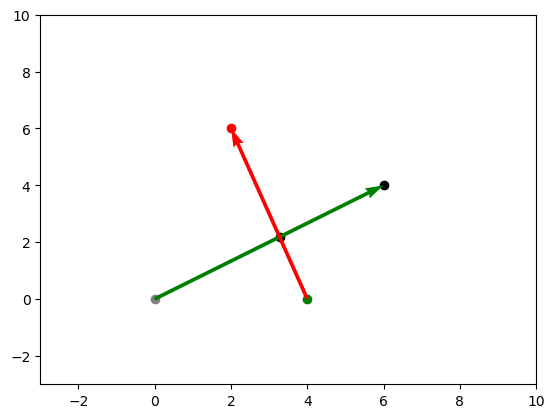

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
A = np.array([4,0])
B = np.array([2,6])
C = np.array([6,4])
D = np.array([0,0])

plt.xlim(-3,10)
plt.ylim(-3,10)
plt.scatter(D[0],D[1], color= 'grey')
plt.scatter(A[0],A[1],color='green')
plt.scatter(B[0], B[1], color='red')
plt.scatter(C[0],C[1],color = 'black')
# plt.scatter(3.2727, 1.1818,color = 'yellow')
plt.scatter( 3.272727272727273, 2.1818181818181817, color='black')
plt.quiver(0, 0, 6,4, angles = "xy", scale_units = "xy", scale = 1, color = 'green')
plt.quiver(A[0], A[1],-2, 6, angles = "xy", scale_units = "xy", scale = 1, color = 'red')
# plt.quiver(0,0,C[0], C[1], angles = "xy", scale_units = "xy", scale = 1, color = 'blue')

plt.show()

In [5]:
A = list(A)
B= list(B)
C = list(C)
D = list(D)
print(A,B,C,D)

pos_slope = (B[1] - A[1])/(B[0] - A[0])
pos_const = A[1] - pos_slope * A[0]

signal_slope = (C[1] - D[1])/(C[0] - D[0])
signal_const = D[1] - signal_slope * D[0]

x_intersept = (signal_const - pos_const)/(pos_slope - signal_slope)
y_intersept = pos_slope * x_intersept + pos_const
print(f'X = {x_intersept} Y = {y_intersept}')
a1,b1,c1 = pos_slope, A[1], pos_const 
a2,b2,c2 =  signal_slope, B[1], signal_const

S = np.array([[a1, b1], [a2, b2]])
b = np.array([-c1, -c2])

print(pos_slope)
print(pos_const)
print(np.linalg.solve(S,b))
print(B[1] == pos_slope * B[0] + pos_const)

[4, 0] [2, 6] [6, 4] [0, 0]
X = 3.272727272727273 Y = 2.1818181818181817
-3.0
12.0
[ 4.         -0.44444444]
True


In [105]:


naklon = 0.03125
angle_radians = math.atan(naklon)
angle_degrees = math.degrees(angle_radians)
angle_radians = math.atan(naklon)

print("Ъгълът в радиани: ", angle_radians)
print("Ъгълът в градуси: ", angle_degrees)
print(math.sin(naklon))
print(math.cos(naklon))

Ъгълът в радиани:  0.031239833430268277
Ъгълът в градуси:  1.7899106082460694
0.03124491398532608
0.9995117584851364
